# Graph-Based Movie Genre Prediction: Unveiling Cinematic Patterns through Network Analysis

Atul Agarwal, Sunishka Jain, Angelic McPherson, Kate Spillane

## Data Processing

In [88]:
import numpy as np
import pandas as pd
import networkx as nx

# Load edges
edges = pd.read_csv('imdb_files/IMDB-MULTI.edges', header=None, names=['node1', 'node2'])

# Load node labels
node_labels = pd.read_csv('imdb_files/IMDB-MULTI.graph_idx', header=None)
node_labels['node'] = node_labels.index + 1

# Load graph labels
graph_labels = pd.read_csv('imdb_files/IMDB-MULTI.graph_labels', header=None, names=['label'])
print(len(edges))
print(len(node_labels))
print(len(graph_labels))

395612
19502
1500


In [89]:
# Create a dictionary of graphs
imdb_graphs = {}
for graph_id in node_labels[0].unique():
    # Create a graph for each unique graph ID
    G = nx.Graph()
    # Add nodes
    nodes = node_labels[node_labels[0] == graph_id]['node']
    G.add_nodes_from(nodes)
    # Add edges
    relevant_edges = edges[(edges['node1'].isin(nodes)) & (edges['node2'].isin(nodes))]
    G.add_edges_from(relevant_edges.values)
    # assign a label to the graph
    G.graph['label'] = graph_labels.loc[graph_id-1, 'label']
    imdb_graphs[graph_id] = G

print(len(imdb_graphs))

1500


In [48]:
# Count the frequency of each label (genre)
genre_counts = graph_labels['label'].value_counts()
# Counts of each genre
print(genre_counts)

1    500
2    500
3    500
Name: label, dtype: int64


## Data Visualization and Analysis

In [49]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from networkx.algorithms.community import k_clique_communities

### Visualize Graphs

In [50]:
# Define color mapping (example: 3 genres mapped to 3 colors)
label_color_mapping = {1: 'red', 2: 'green', 3: 'blue'}  # Update this based on your actual labels

# Function to draw a graph with nodes colored by their label
def draw_graph_with_colors(G, genre_label, title="Graph"):
    # Assuming G.graph['label'] is the label for color-coding
    color = label_color_mapping.get(G.graph[genre_label], 'gray')  # Default to gray if label not found

    plt.figure(figsize=(8, 6))
    nx.draw(G, node_color=color, with_labels=True)
    plt.title(title)
    plt.show()

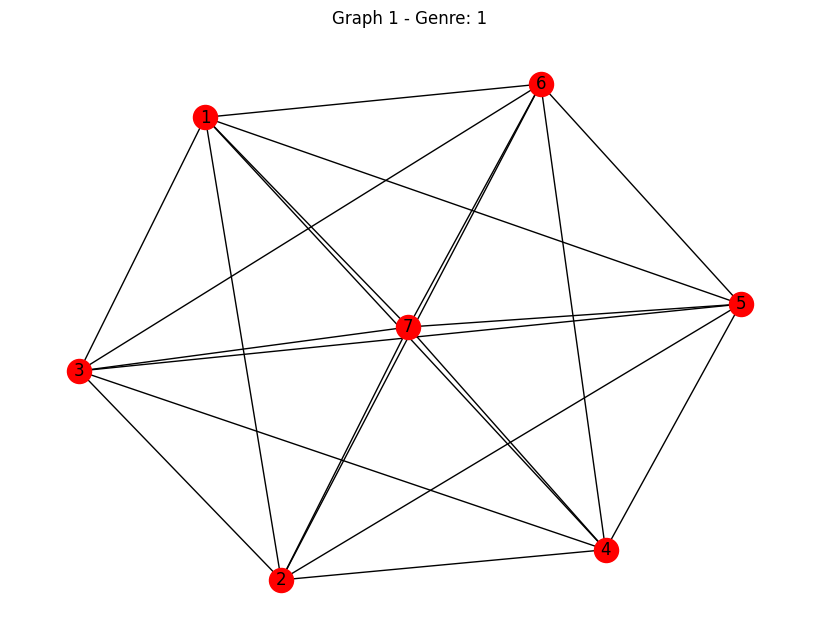

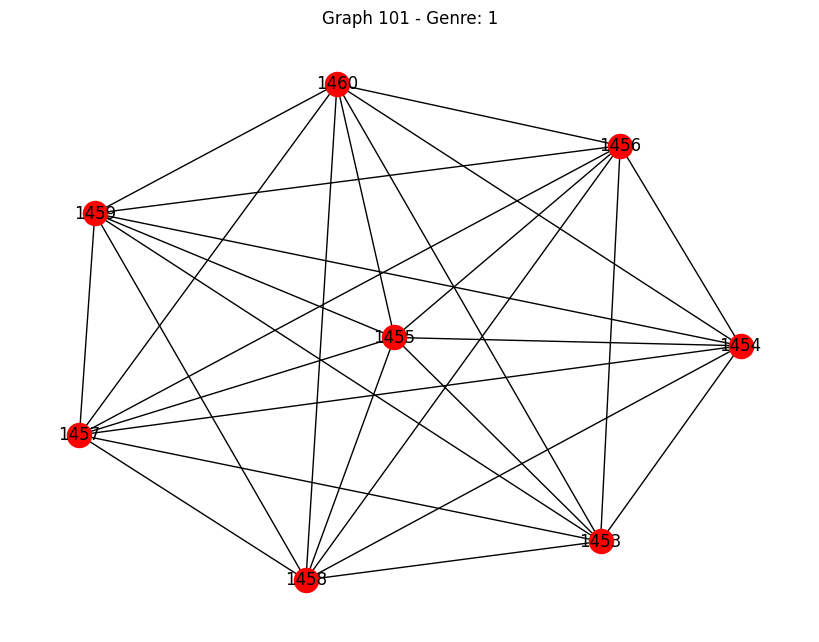

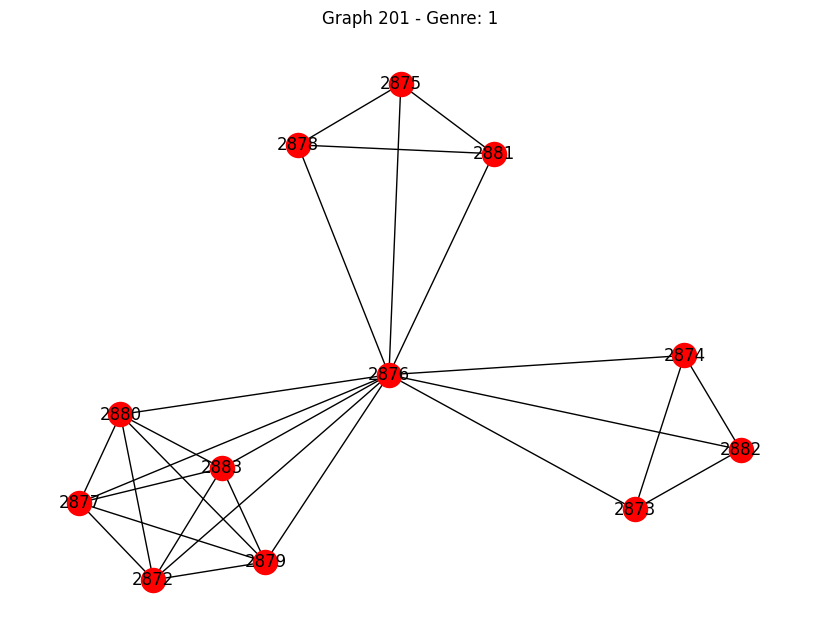

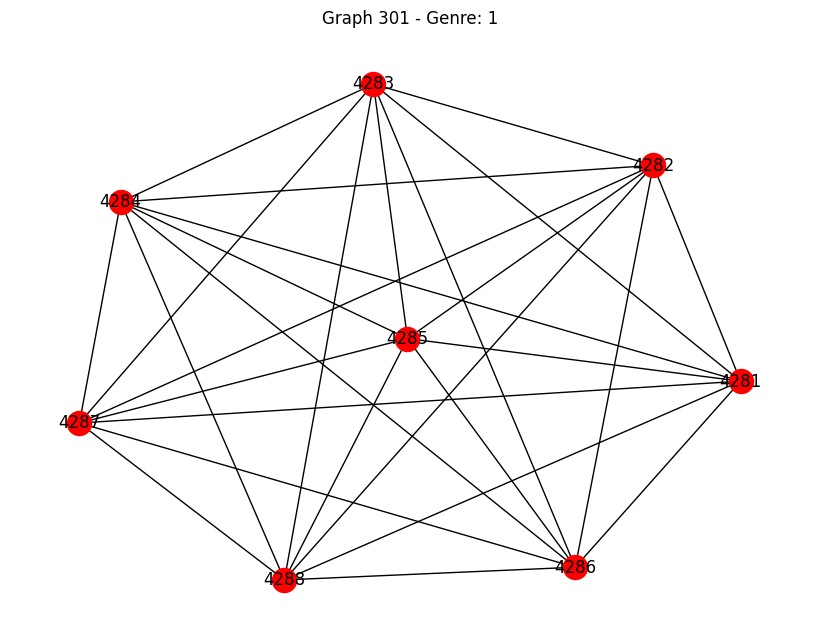

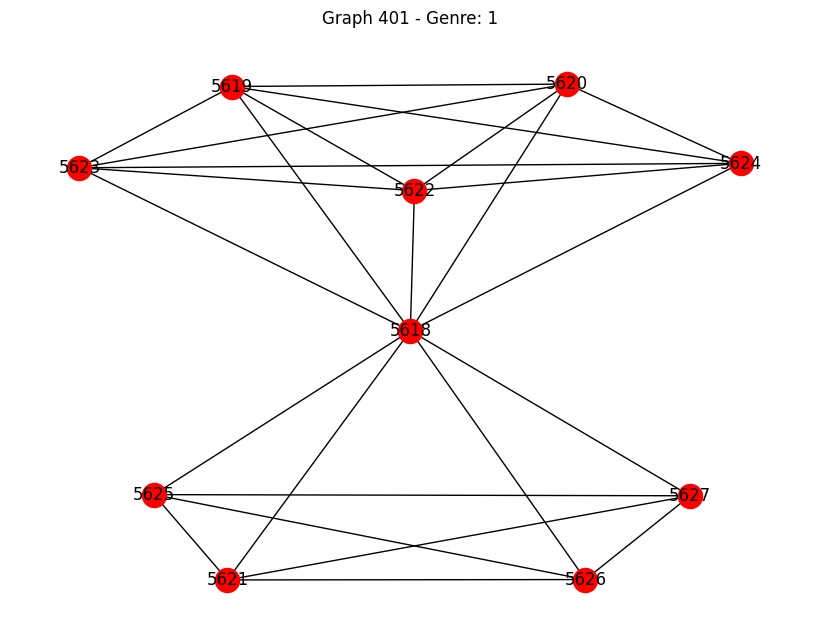

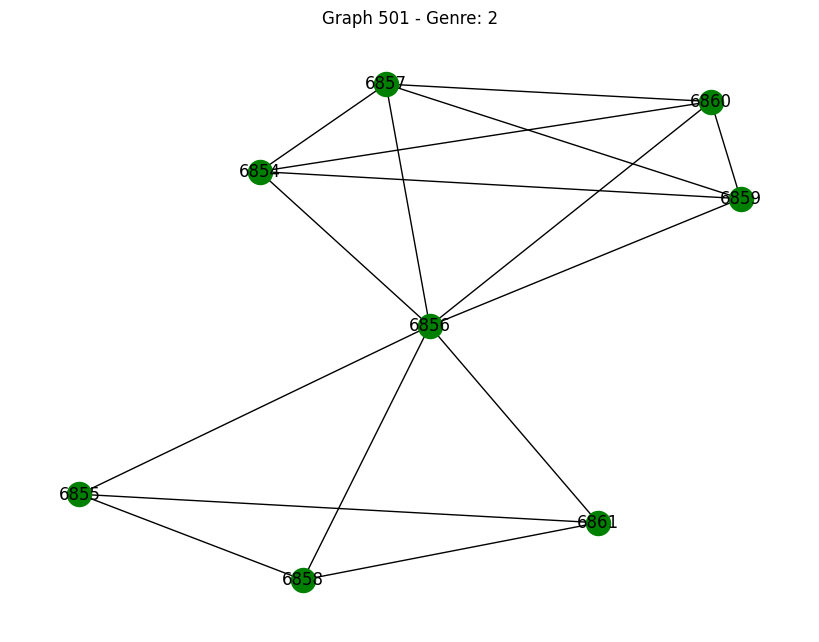

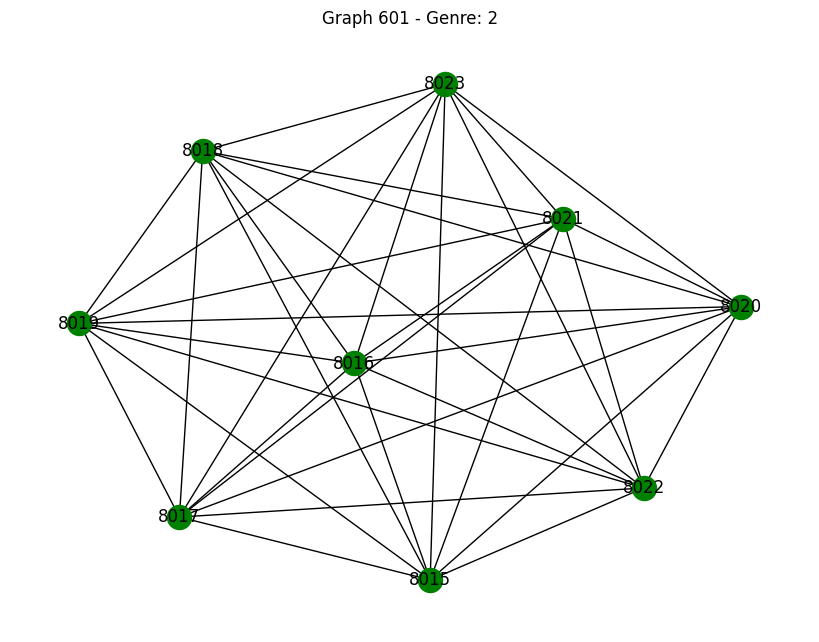

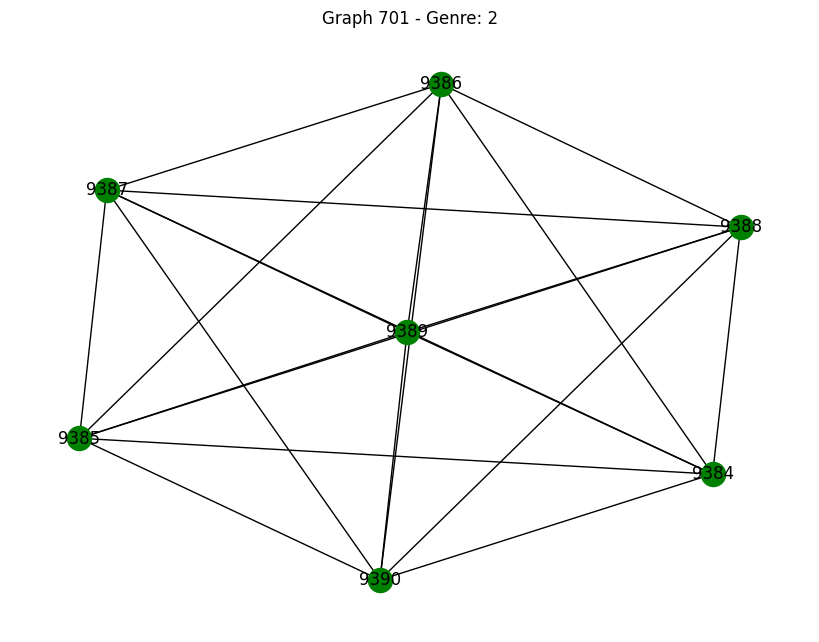

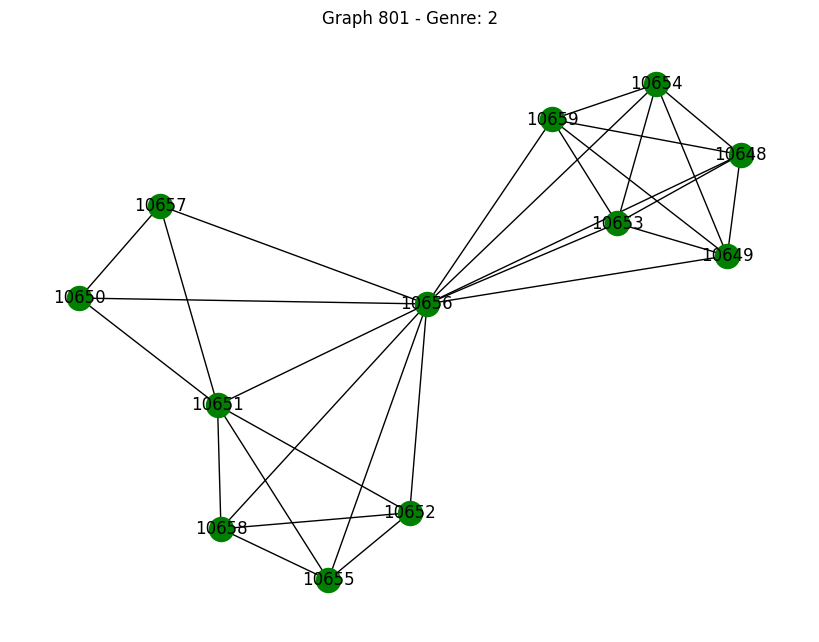

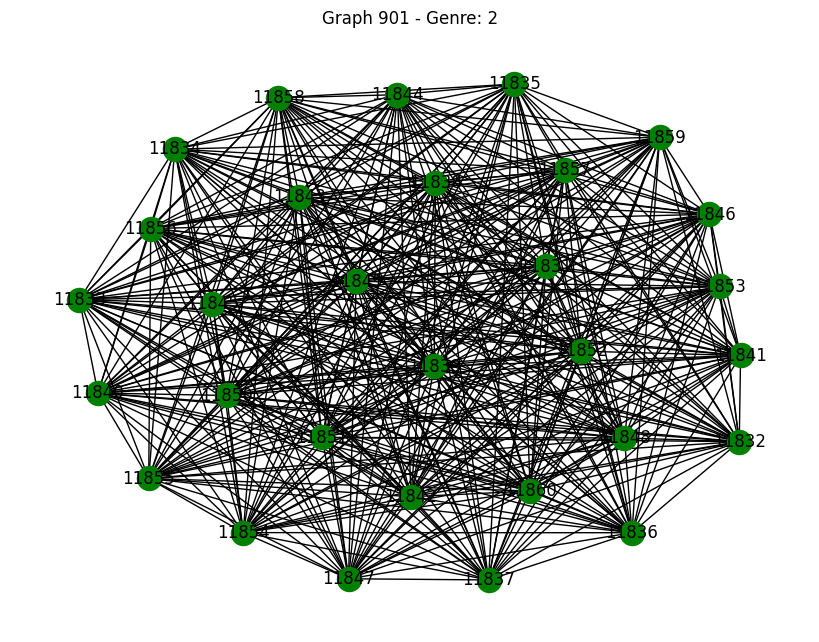

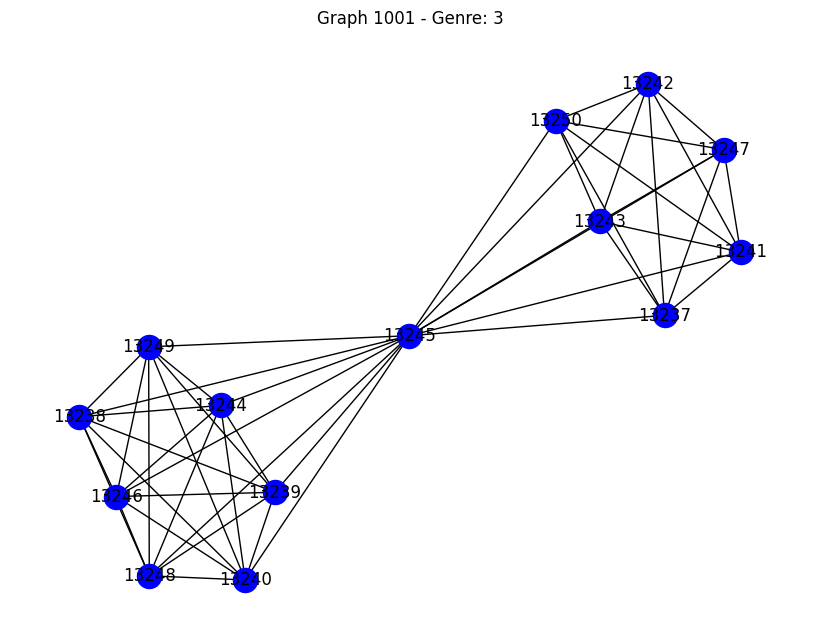

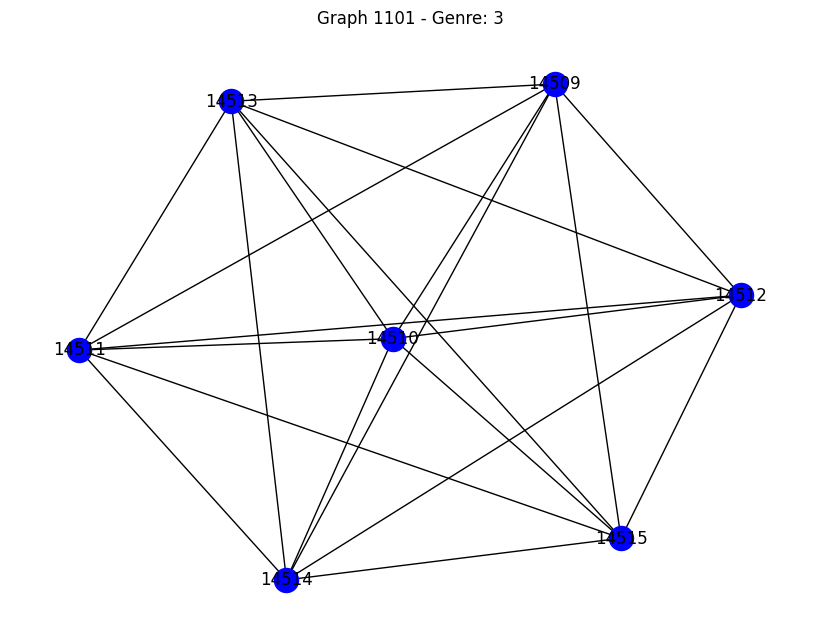

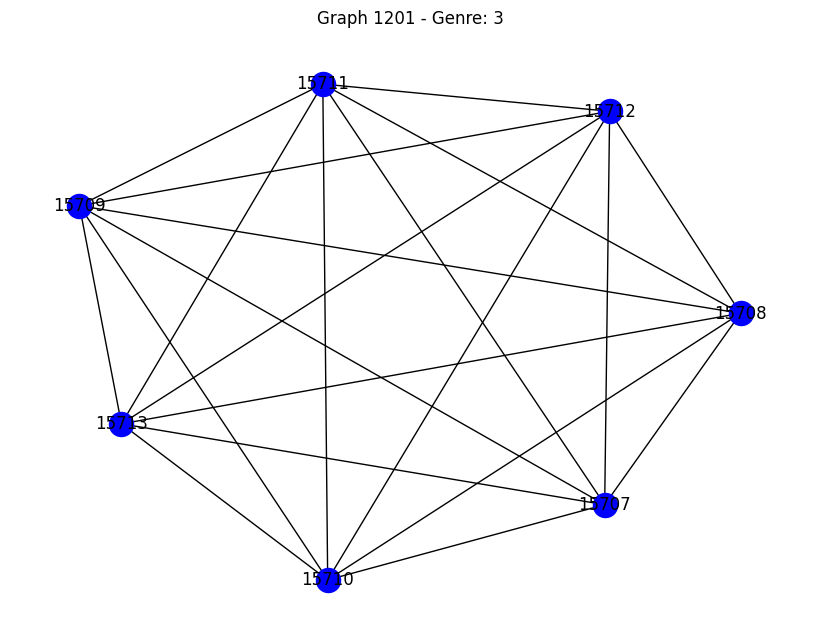

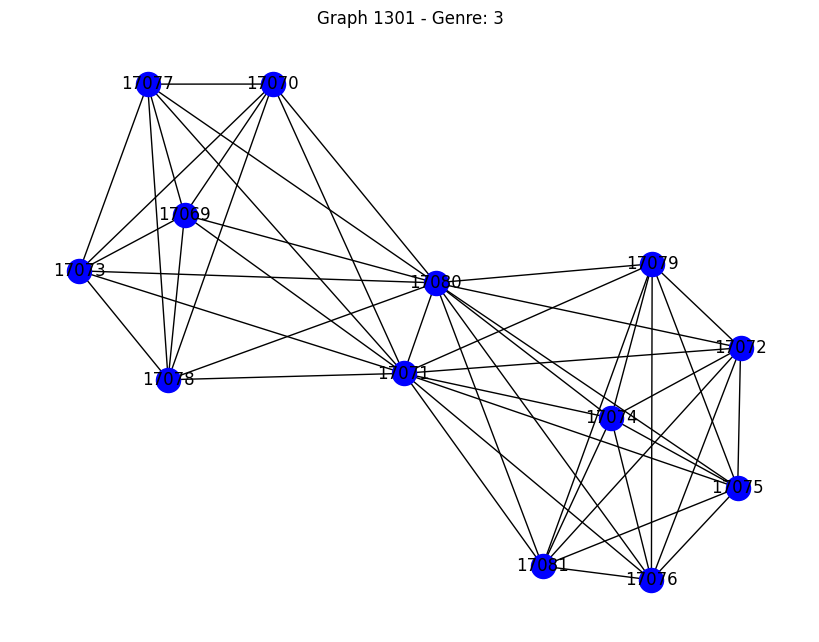

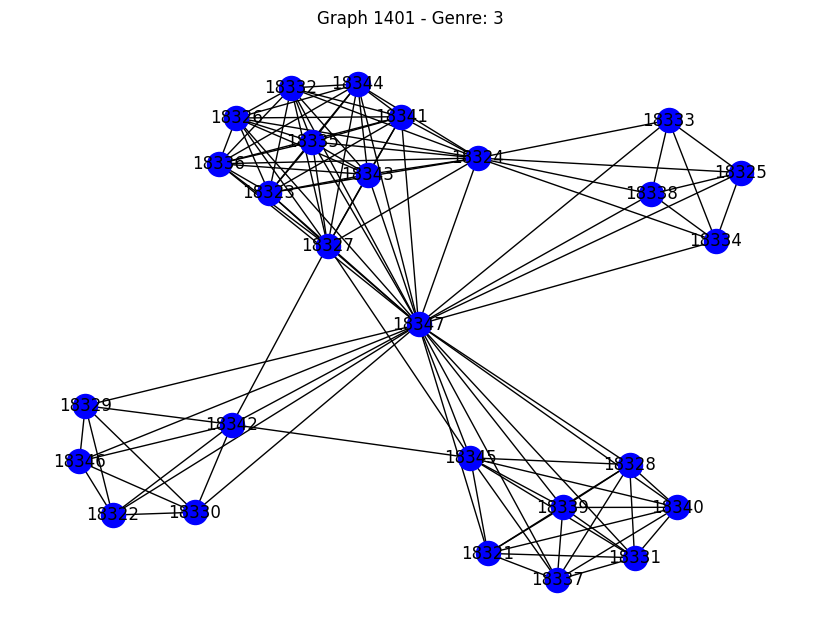

In [51]:
# Optionally, limit the number of graphs to draw, as drawing many graphs can be time-consuming
graphs_to_draw = list(imdb_graphs.keys())[::100]  # Adjust the slice as needed

for graph_id in graphs_to_draw:
    G = imdb_graphs[graph_id]
    draw_graph_with_colors(G, 'label', title=f"Graph {graph_id} - Genre: {G.graph['label']}")

### Calculate and visualize metrics

Below is the metric calculation of all of the graphs. We calculated clustering coefficient, node degrees, number of triangles, number of connected components, path length, density, and diameter. The averages are then taken and printed and visualized below.

In [52]:
# Assuming 'graphs' is a dictionary of NetworkX graph objects indexed by some identifier, with each graph labeled by genre
def metrics(graph_dict_name, label_name):
  metrics_by_genre = {}

  for graph_id, G in graph_dict_name.items():
      genre = G.graph[label_name]  # Ensure your graph objects have a 'label' attribute denoting their genre
      if genre not in metrics_by_genre:
          metrics_by_genre[genre] = {'clustering_coefficients': [],
                                     'node_degrees': [],
                                     'triangles': [],
                                     'connected_components': [],
                                     'path_lengths': [],
                                     'densities': [],
                                     'diameters': [],
                                     'node_edge_ratio': [],
                                     'num_communities': []}

      # Compute existing metrics
      avg_clustering_coefficient = nx.average_clustering(G)
      avg_node_degree = np.mean([degree for node, degree in G.degree()])
      triangles = sum(nx.triangles(G).values()) / 3  # Each triangle is counted 3 times
      num_connected_components = nx.number_connected_components(G)
      if nx.is_connected(G):
          avg_path_length = nx.average_shortest_path_length(G)
          diameter = nx.diameter(G)  # Only valid for connected graphs
      else:
          avg_path_length = np.nan  # Handle disconnected graphs
          diameter = np.nan  # Consider handling differently for disconnected graphs

      # Compute density
      density = nx.density(G)

      # Compute Node-Edge Ratio
      node_edge_ratio = len(G.nodes) / len(G.edges)

      # Compute Number of Communities (using k-clique communities as an example)
      k = 3  # Choose the desired value of k
      communities = list(k_clique_communities(G, k))
      num_communities = len(communities)


      # Store new metrics
      metrics_by_genre[genre]['clustering_coefficients'].append(avg_clustering_coefficient)
      metrics_by_genre[genre]['node_degrees'].append(avg_node_degree)
      metrics_by_genre[genre]['triangles'].append(triangles)
      metrics_by_genre[genre]['path_lengths'].append(avg_path_length)
      metrics_by_genre[genre]['densities'].append(density)
      metrics_by_genre[genre]['diameters'].append(diameter)

      metrics_by_genre[genre]['node_edge_ratio'].append(node_edge_ratio)
      metrics_by_genre[genre]['num_communities'].append(num_communities)

  # Aggregate metrics by genre and compute averages, including new metrics
  avg_metrics_by_genre = {}
  for genre, metrics in metrics_by_genre.items():
      avg_clustering = np.mean(metrics['clustering_coefficients'])
      avg_degree = np.mean(metrics['node_degrees'])
      avg_triangles = np.mean(metrics['triangles'])
      avg_path_length = np.nanmean(metrics['path_lengths'])  # Using nanmean to handle NaN values
      avg_density = np.mean(metrics['densities'])
      avg_diameter = np.nanmean(metrics['diameters'])  # Using nanmean to handle NaN values for disconnected graphs

      # Compute averages for additional metrics
      avg_node_edge_ratio = np.mean(metrics['node_edge_ratio'])
      avg_num_communities = np.mean(metrics['num_communities'])

      avg_metrics_by_genre[genre] = {'avg_clustering_coefficient': avg_clustering,
                                    'avg_node_degree': avg_degree,
                                    'avg_triangles': avg_triangles,
                                    'avg_path_length': avg_path_length,
                                    'avg_density': avg_density,
                                    'avg_diameter': avg_diameter,
                                    'avg_node_edge_ratio': avg_node_edge_ratio,
                                    'avg_num_communities': avg_num_communities}

  # Print the results, including new metrics
  for genre, avg_metrics in avg_metrics_by_genre.items():
      print(f"Genre {genre}: Avg Clustering Coefficient = {avg_metrics['avg_clustering_coefficient']}, "
            f"Avg Node Degree = {avg_metrics['avg_node_degree']}, "
            f"Avg Number of Triangles = {avg_metrics['avg_triangles']}, "
            f"Avg Path Length = {avg_metrics['avg_path_length']}, "
            f"Avg Density = {avg_metrics['avg_density']}, "
            f"Avg Diameter = {avg_metrics['avg_diameter']}, "
            f"Avg Node Edge Ratio = {avg_metrics['avg_node_edge_ratio']}, "
            f"Avg Number of Communities = {avg_metrics['avg_num_communities']}")



In [53]:
metrics(imdb_graphs, 'label')

Genre 1: Avg Clustering Coefficient = 0.9632712150716378, Avg Node Degree = 7.770777496695546, Avg Number of Triangles = 275.3, Avg Path Length = 1.2827013886435465, Avg Density = 0.7172986113564535, Avg Diameter = 1.56, Avg Node Edge Ratio = 0.3015019502658176, Avg Number of Communities = 1.716
Genre 2: Avg Clustering Coefficient = 0.9711033274858505, Avg Node Degree = 8.049477222992797, Avg Number of Triangles = 430.276, Avg Path Length = 1.233619105050442, Avg Density = 0.7663808949495582, Avg Diameter = 1.478, Avg Node Edge Ratio = 0.3088493247915298, Avg Number of Communities = 1.556
Genre 3: Avg Clustering Coefficient = 0.9730565383626176, Avg Node Degree = 8.483269887446863, Avg Number of Triangles = 212.124, Avg Path Length = 1.1662127079540114, Avg Density = 0.8337872920459886, Avg Diameter = 1.384, Avg Node Edge Ratio = 0.26488486684783014, Avg Number of Communities = 1.262


In [54]:
def visualize_metrics1(graph_dict_name, label_name):
  clustering_coeffs = []
  path_lengths = []
  triangles = []
  avg_degrees = []
  genres = []
  densities = []
  diameters = []
  node_edge_ratio = []
  num_communities = []


  for G in graph_dict_name.values():
      genre = G.graph[label_name]  # Assuming this is how you've stored the genre/label
      genres.append(genre)
      clustering_coeffs.append(nx.average_clustering(G))
      density = nx.density(G)
      densities.append(density)

      if nx.is_connected(G):
          diameter = nx.diameter(G)
          path_lengths.append(nx.average_shortest_path_length(G))
      else:
          largest_cc = max(nx.connected_components(G), key=len)
          subgraph = G.subgraph(largest_cc)
          path_lengths.append(nx.average_shortest_path_length(subgraph))
          diameter = nx.diameter(subgraph)
      diameters.append(diameter)

      triangles.append(sum(nx.triangles(G).values()) / 3)  # Each triangle is counted 3 times
      avg_degrees.append(sum(dict(G.degree()).values()) / len(G.nodes()))

      # Compute Node-Edge Ratio
      node_edge_ratio.append(len(G.nodes) / len(G.edges))

      # Compute Number of Communities (using k-clique communities as an example)
      k = 3  # Choose the desired value of k
      communities = list(k_clique_communities(G, k))
      num_communities.append(len(communities))

  # Create a DataFrame for easier plotting
  metrics_df = pd.DataFrame({
      'Genre': genres,
      'Clustering Coefficients': clustering_coeffs,
      'Path Lengths': path_lengths,
      'Triangles': triangles,
      'Average Degrees': avg_degrees,
      'Density': densities,
      'Diameter': diameters,
      'Node Edge Ratio': node_edge_ratio,
      'Number of Communities': num_communities
  })

  fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24, 5), sharey=False)

  sns.violinplot(data=metrics_df['Clustering Coefficients'], ax=axes[0], color="skyblue")
  axes[0].set_title('Clustering Coefficients')

  sns.violinplot(data=metrics_df['Path Lengths'], ax=axes[1], color="lightgreen")
  axes[1].set_title('Path Lengths')

  sns.violinplot(data=metrics_df['Triangles'], ax=axes[2], color="lightcoral")
  axes[2].set_title('Triangles')

  sns.violinplot(data=metrics_df['Average Degrees'], ax=axes[3], color="violet")
  axes[3].set_title('Average Degrees')

  # New plots for Density and Diameter
  sns.violinplot(data=metrics_df['Density'], ax=axes[4], color="gold")
  axes[4].set_title('Density')

  sns.violinplot(data=metrics_df['Diameter'], ax=axes[5], color="teal")
  axes[5].set_title('Diameter')

  sns.violinplot(data=metrics_df['Node Edge Ratio'], ax=axes[6], color="beige")
  axes[6].set_title('Node Edge Ratio')

  sns.violinplot(data=metrics_df['Number of Communities'], ax=axes[7], color="pink")
  axes[7].set_title('Number of Communities')

  # Adjust layout
  plt.tight_layout()
  plt.show()

  return metrics_df

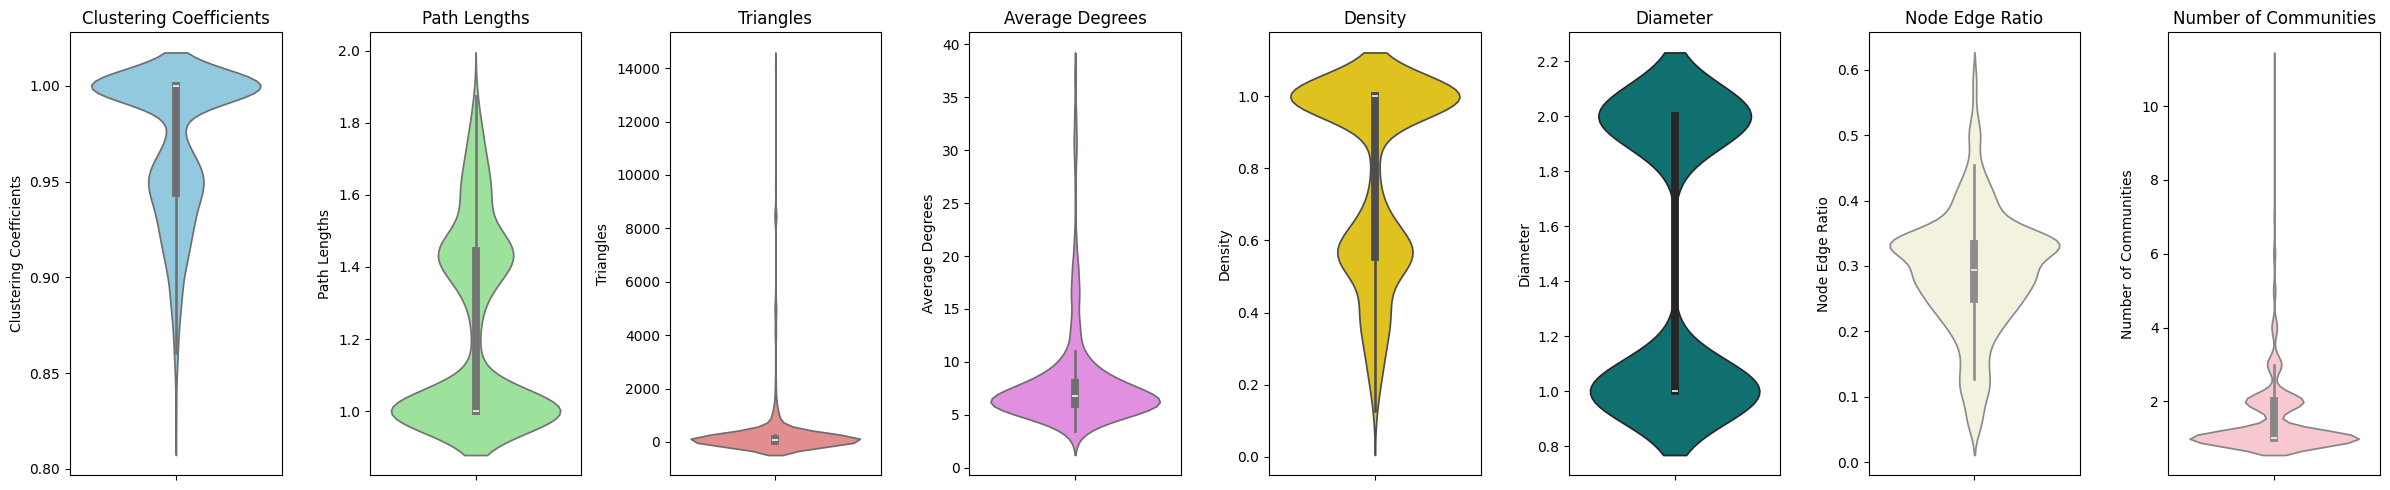

In [55]:
metrics_IMDb = visualize_metrics1(imdb_graphs, 'label')

Below are the calculated metrics, but separated by genre.

In [56]:
def visualize_metrics2(metrics_df):
  # Plotting with genres correctly using `hue`
  fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24, 5), sharey=False)

  sns.violinplot(x='Genre', y='Clustering Coefficients', hue='Genre', data=metrics_df, ax=axes[0], palette="Pastel1", legend=False)
  axes[0].set_title('Clustering Coefficients by Genre')

  sns.violinplot(x='Genre', y='Path Lengths', hue='Genre', data=metrics_df, ax=axes[1], palette="Pastel1", legend=False)
  axes[1].set_title('Path Lengths by Genre')

  sns.violinplot(x='Genre', y='Triangles', hue='Genre', data=metrics_df, ax=axes[2], palette="Pastel1", legend=False)
  axes[2].set_title('Triangles by Genre')

  sns.violinplot(x='Genre', y='Average Degrees', hue='Genre', data=metrics_df, ax=axes[3], palette="Pastel1", legend=False)
  axes[3].set_title('Average Degrees by Genre')

  sns.violinplot(x='Genre', y='Density', hue='Genre', data=metrics_df, ax=axes[4], palette="Pastel1", dodge=False)
  axes[4].set_title('Density by Genre')
  axes[4].get_legend().remove()

  sns.violinplot(x='Genre', y='Diameter', hue='Genre', data=metrics_df, ax=axes[5], palette="Pastel1", dodge=False)
  axes[5].set_title('Diameter by Genre')
  axes[5].get_legend().remove()

  sns.violinplot(x='Genre', y='Node Edge Ratio', hue='Genre', data=metrics_df, ax=axes[6], palette="Pastel1", dodge=False)
  axes[6].set_title('Node Edge Ratio by Genre')
  axes[6].get_legend().remove()

  sns.violinplot(x='Genre', y='Number of Communities', hue='Genre', data=metrics_df, ax=axes[7], palette="Pastel1", dodge=False)
  axes[7].set_title('Number of Communities by Genre')
  axes[7].get_legend().remove()

  plt.tight_layout()
  plt.show()

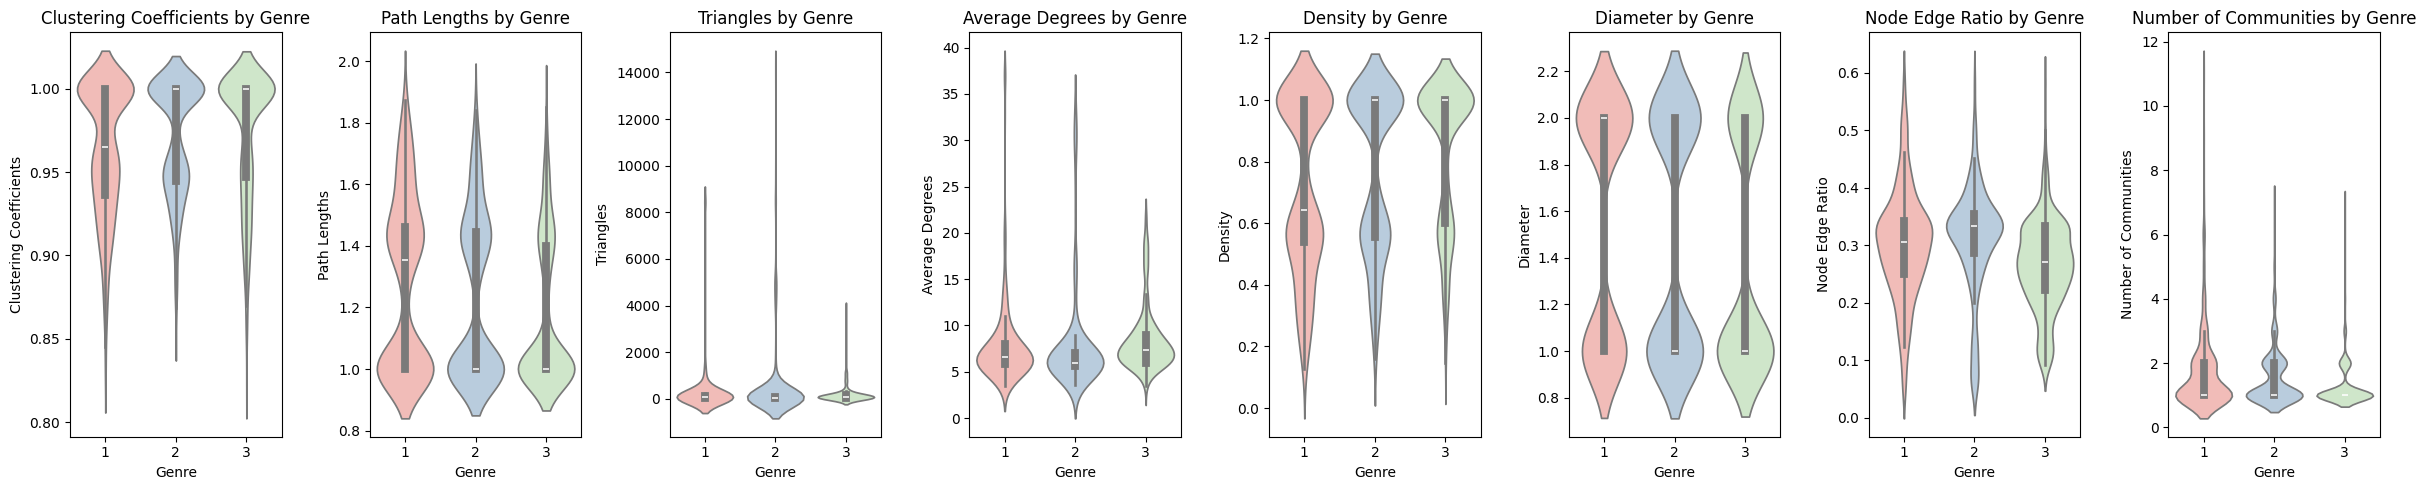

In [57]:
visualize_metrics2(metrics_IMDb)

In [58]:
# Create lists to separate graphs by genre
label_one_graphs = []
label_two_graphs = []
label_three_graphs = []
for i in imdb_graphs:
  G = imdb_graphs[i]
  if(G.graph['label']==1):
    label_one_graphs.append(G)
  elif(G.graph['label']==2):
    label_two_graphs.append(G)
  else:
    label_three_graphs.append(G)

Below is the aggregated degree distribution for each genre.

In [59]:
from collections import defaultdict

def aggregate_degree_distrib(graph_genre, genre_num, color):
  # Assuming `graphs` is a list of your NetworkX graphs for a single category
  def calculate_degree_distribution(graph):
      degrees = [degree for node, degree in graph.degree()]
      degree_distribution = defaultdict(int)
      for degree in degrees:
          degree_distribution[degree] += 1
      return degree_distribution

  # Aggregate degree distributions from all graphs in the category
  aggregate_distribution = defaultdict(int)
  for g in graph_genre:
      graph_distribution = calculate_degree_distribution(g)
      for degree, count in graph_distribution.items():
          aggregate_distribution[degree] += count

  # Convert the aggregated distribution to a DataFrame for Seaborn
  data = {"Degree": [], "Proportion": []}
  total_nodes = sum(aggregate_distribution.values())
  for degree, count in aggregate_distribution.items():
      data["Degree"].append(degree)
      data["Proportion"].append(count / total_nodes)

  df = pd.DataFrame(data)

  # Plotting with Seaborn
  plt.figure(figsize=(10, 6))
  sns.barplot(data=df, x="Degree", y="Proportion", color=color, errorbar=None)
  plt.title(f"Aggregated Degree Distribution for Genre {genre_num}")
  plt.xlabel("Degree")
  plt.ylabel("Proportion of Nodes")
  plt.xscale('log')  # Use logarithmic scale if needed
  plt.yscale('log')  # Use logarithmic scale if distributions are very skewed
  # plt.xticks(rotation=45)  # Rotate x-axis labels if they overlap
  plt.tight_layout()
  plt.show()

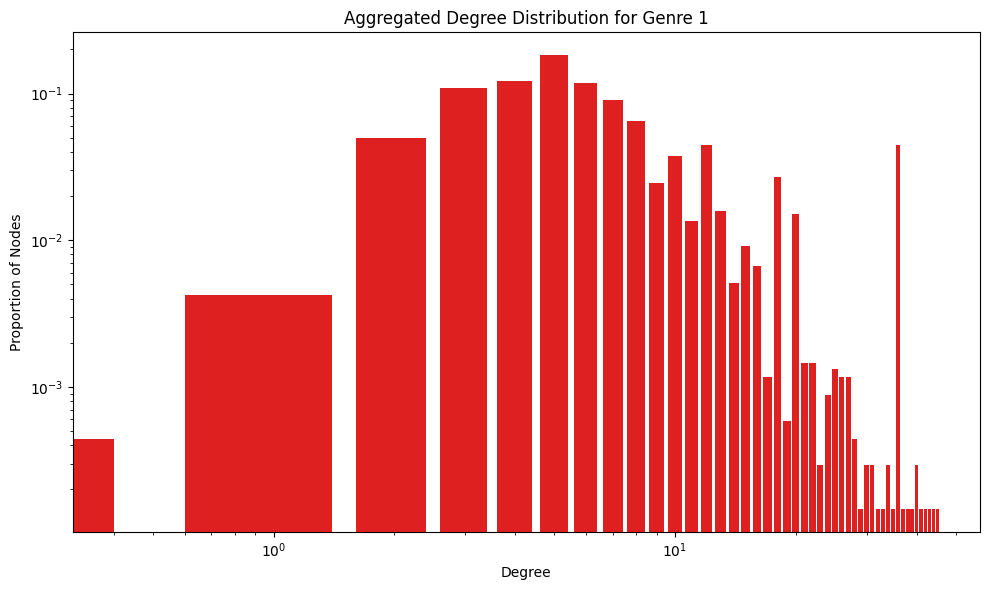

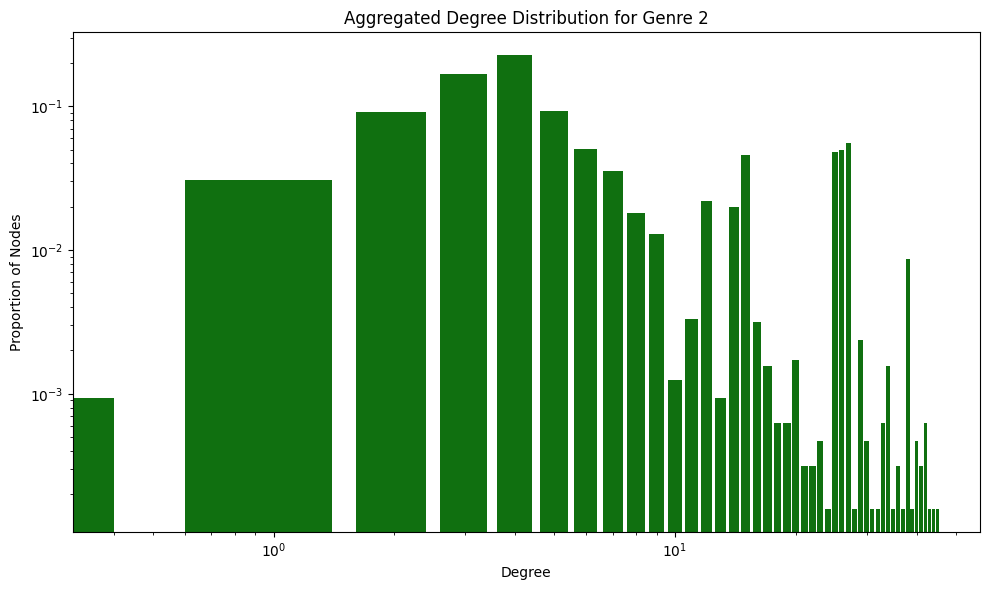

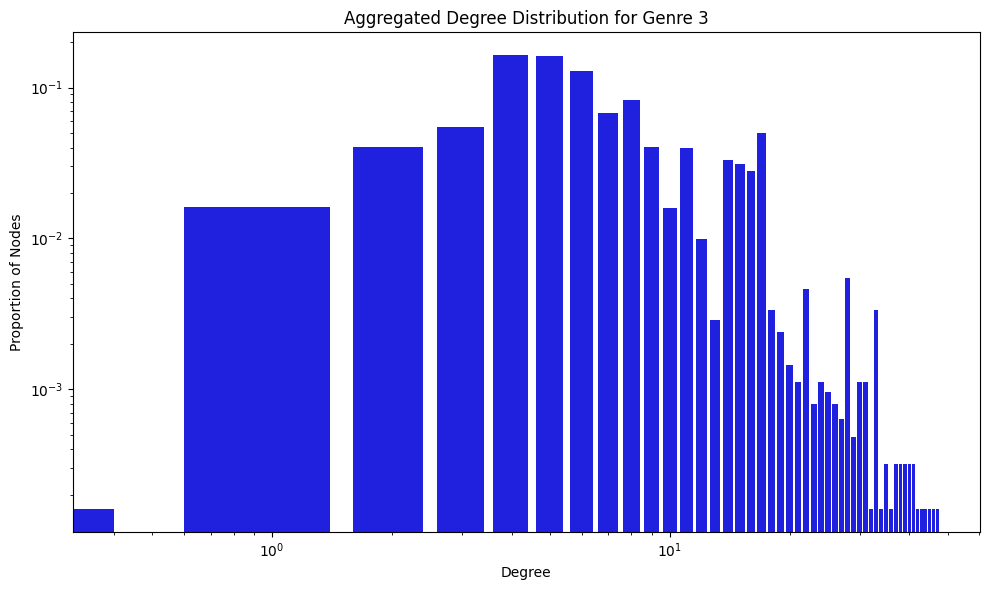

In [60]:
aggregate_degree_distrib(label_one_graphs, 1, label_color_mapping[1])
aggregate_degree_distrib(label_two_graphs, 2, label_color_mapping[2])
aggregate_degree_distrib(label_three_graphs, 3, label_color_mapping[3])

Below is the degree distribution for each genre.

In [61]:
from collections import Counter

def degree_distrib(graph_genre, genre_num, color):
  degree_counts = Counter()
  for graph in graph_genre:
      degrees = [degree for node, degree in graph.degree()]
      degree_counts.update(degrees)

  # Convert to probabilities
  total_count = sum(degree_counts.values())
  degrees, counts = zip(*degree_counts.items())
  probabilities = [count / total_count for count in counts]

  # Prepare for log-log plot
  log_degrees = np.log(degrees)
  log_probabilities = np.log(probabilities)

  # Plotting
  plt.figure(figsize=(10, 6))
  plt.scatter(log_degrees, log_probabilities, color=color)
  plt.title(f"Log-Log Plot of Degree Distribution for Genre {genre_num}")
  plt.xlabel("Log(Degree)")
  plt.ylabel("Log(Probability)")
  plt.grid(True, which="both", ls="--")
  plt.show()


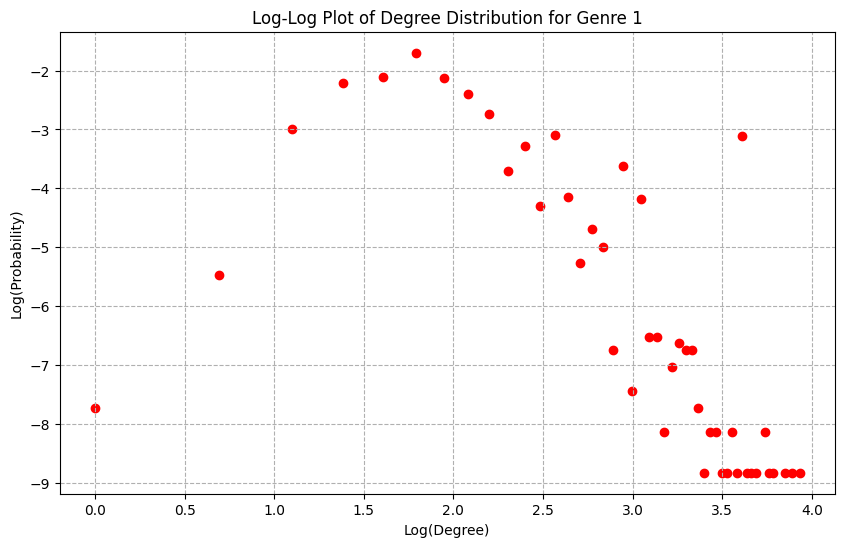

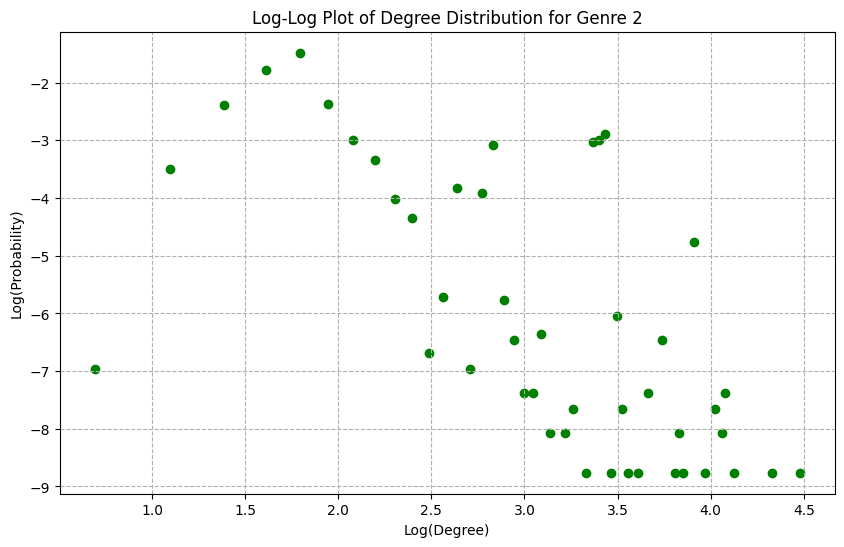

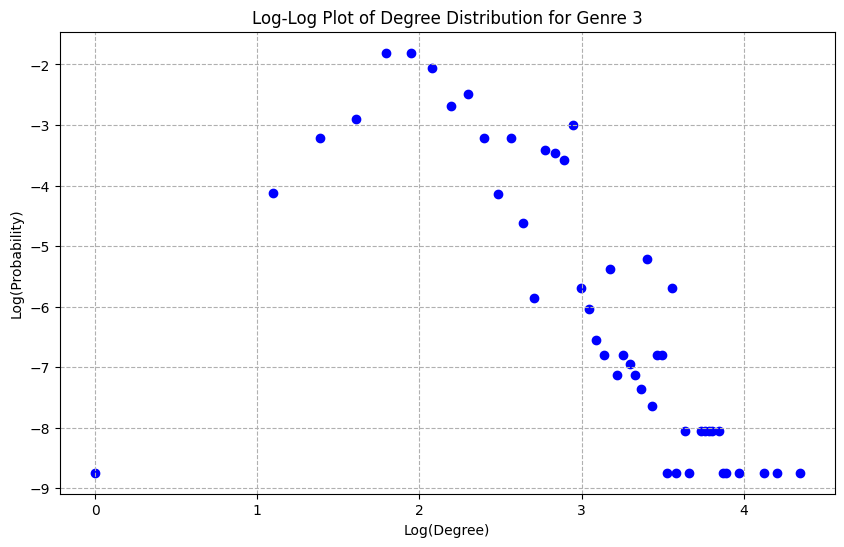

In [62]:
degree_distrib(label_one_graphs, 1, label_color_mapping[1])
degree_distrib(label_two_graphs, 2, label_color_mapping[2])
degree_distrib(label_three_graphs, 3, label_color_mapping[3])

We calculate 4 centralities: degree, betweeness, closeness, and eigenvector centrality. Below is the eigenvector centrality for each genre.

In [63]:
# Calculate centrality measures for each graph
def calculate_centralities(graph_set):
  avg_degree_centrality = []
  avg_betweenness_centrality = []
  avg_closeness_centrality = []
  avg_eigenvector_centrality = []
  for G in graph_set:
      # Degree Centrality
      degree_centrality = nx.degree_centrality(G)
      avg_degree_centrality.append(np.mean(list(degree_centrality.values())))

      # Betweenness Centrality
      betweenness_centrality = nx.betweenness_centrality(G)
      avg_betweenness_centrality.append(np.mean(list(betweenness_centrality.values())))

      # Closeness Centrality
      closeness_centrality = nx.closeness_centrality(G)
      avg_closeness_centrality.append(np.mean(list(closeness_centrality.values())))

      # Eigenvector Centrality
      try:
          eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
          avg_eigenvector_centrality.append(np.mean(list(eigenvector_centrality.values())))
      except nx.PowerIterationFailedConvergence:
          avg_eigenvector_centrality.append(None)  # Handle graphs where Eigenvector Centrality fails to converge
  return [avg_degree_centrality, avg_betweenness_centrality, avg_closeness_centrality, avg_eigenvector_centrality]


In [64]:
def plot_centralities(centrality_type, title, color):
  plt.figure(figsize=(10, 6))
  plt.hist(centrality_type, bins=30, alpha=0.75, color=color)
  plt.title(title)
  plt.xlabel('Average Degree Centrality')
  plt.ylabel('Frequency')
  plt.show()

In [65]:
avg_degree_centrality_one, avg_betweenness_centrality_one, avg_closeness_centrality_one, avg_eigenvector_centrality_one = calculate_centralities(label_one_graphs)
avg_degree_centrality_two, avg_betweenness_centrality_two, avg_closeness_centrality_two, avg_eigenvector_centrality_two = calculate_centralities(label_two_graphs)
avg_degree_centrality_three, avg_betweenness_centrality_three, avg_closeness_centrality_three, avg_eigenvector_centrality_three = calculate_centralities(label_three_graphs)

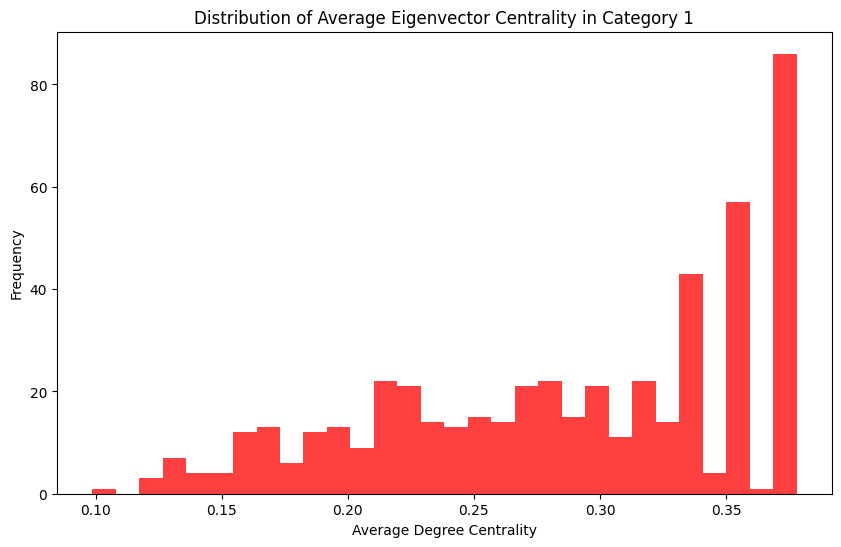

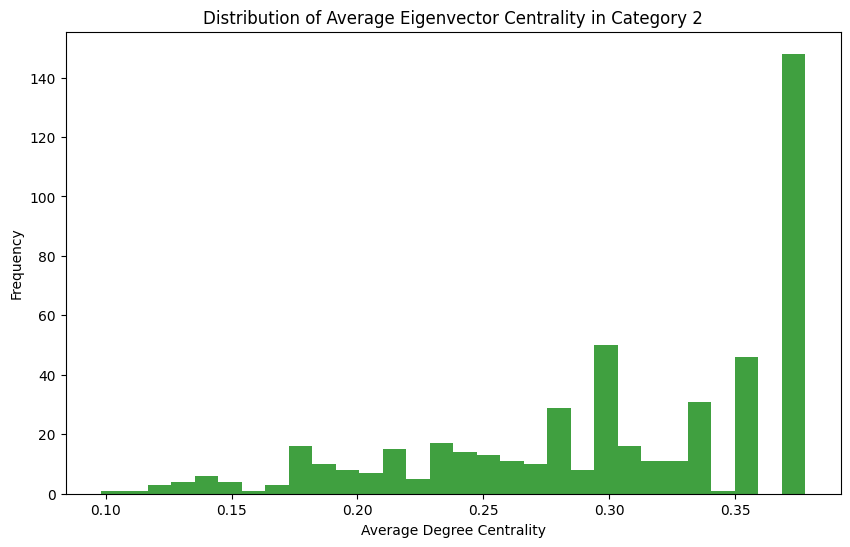

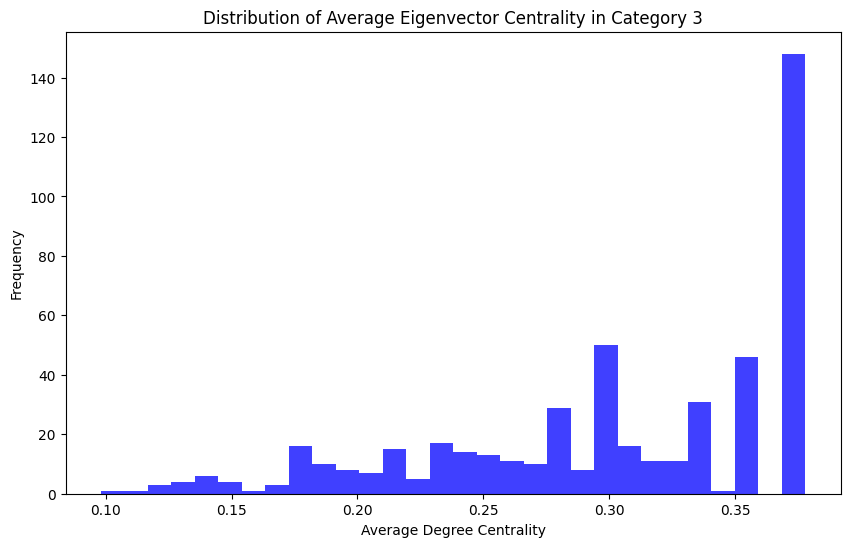

In [66]:
plot_centralities(avg_eigenvector_centrality_one, 'Distribution of Average Eigenvector Centrality in Category 1', label_color_mapping[1])
plot_centralities(avg_eigenvector_centrality_two, 'Distribution of Average Eigenvector Centrality in Category 2', label_color_mapping[2])
plot_centralities(avg_eigenvector_centrality_two, 'Distribution of Average Eigenvector Centrality in Category 3', label_color_mapping[3])

## Model Training

In [67]:
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse as sp
import networkx as nx
from torch_geometric.data import Data

### Graph conversion and embedding

In [90]:
def embed(graph):
    # Calculate and set clustering coefficients as node attribute
    clustering_coeffs = nx.clustering(graph)
    nx.set_node_attributes(graph, clustering_coeffs, 'clustering_coefficient')

    # Calculate and set eigenvector centrality as node attribute
    eigenvector_centrality = nx.eigenvector_centrality(graph)
    nx.set_node_attributes(graph, eigenvector_centrality, 'eigenvector_centrality')

# Assuming you have a dictionary of graphs named 'graphs'
for graph in imdb_graphs.values():
    embed(graph)

In [69]:
import numpy as np
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# Function to calculate the number of triangles
def calculate_triangles(G):
    # Use NetworkX to calculate the total number of triangles in the graph
    triangles = sum(nx.triangles(G).values()) / 3
    return triangles

def nx_to_pyg_graph(G, label):

    # Get node mapping to ensure consistent ordering
    node_mapping = {node: i for i, node in enumerate(G.nodes())}

    # Convert edges to PyTorch tensor
    edge_index = torch.tensor([[node_mapping[node1], node_mapping[node2]] for node1, node2 in G.edges()], dtype=torch.long).t().contiguous()

    num_features = 2
    features = np.zeros((len(G.nodes()), num_features))
    for i, node in enumerate(G.nodes()):
        features[i, 0] = G.nodes[node].get('eigenvector_centrality', 0)
        features[i, 1] = G.nodes[node].get('clustering_coefficient', 0)

    # Convert features to a PyTorch tensor
    x = torch.tensor(features, dtype=torch.float)

    # Convert graph label
    y = torch.tensor([G.graph[label]], dtype=torch.long)

    # Calculate and normalize number of triangles
    triangles = calculate_triangles(G)
    normalization_factor = len(G.nodes())
    normalized_triangles = triangles / normalization_factor

    # Calculate shortest path
    shortest_path = nx.average_shortest_path_length(G)

    # Number of communities
    communities = list(greedy_modularity_communities(G))
    num_communities = len(communities)

    # Simple metrics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    diameter = nx.diameter(G)

    graph_features = np.array([[normalized_triangles], [shortest_path/diameter], [num_nodes / num_edges], [num_communities]])
    graph_feature_tensor = torch.tensor(graph_features, dtype=torch.float).view(1, -1)

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, y=y, graph_feature=graph_feature_tensor)
    return data



In [70]:
imdb_pyg_graphs = [nx_to_pyg_graph(G, 'label') for G in imdb_graphs.values()]

### GraphSAGE

First, we retrieve train a GraphSAGE model and use it to retrieve node embeddings for each graph

In [71]:
from torch_geometric.nn import SAGEConv, global_mean_pool

class GraphSAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGENet, self).__init__()
        self.conv_layers = nn.ModuleList()

        self.conv1 = SAGEConv(in_channels, hidden_channels, normalize=True)
        self.conv2 = SAGEConv(hidden_channels, out_channels, normalize=True)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # First GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        #  Second GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # Aggregate node features to graph-level features
        x = global_mean_pool(x, batch)
        return x

In [72]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Split graphs into training and test sets
train_graphs, test_graphs = train_test_split(imdb_pyg_graphs, test_size=0.2, random_state=42)

# Create DataLoaders
train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=64, shuffle=False)

In [73]:
model = GraphSAGENet(in_channels=2, hidden_channels=2, out_channels=2)

def get_node_embeddings(model, data):
    with torch.no_grad():  # No need to track gradients
        # Forward pass through the model
        embeddings = model(data)
    return embeddings

for pyg_graph in train_graphs:
    # Get node embeddings for the current graph
    node_embeddings = get_node_embeddings(model, pyg_graph)
    pyg_graph.x += node_embeddings

### Incorporate edge weights

Run one of the three cells below to compute edge weight based on node similarity measures


In [74]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

for pyg_graph in imdb_pyg_graphs:
    s = MinMaxScaler()
    node_features = s.fit_transform(pyg_graph.x.numpy())
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_weights  = cosine_similarity(node_features[pyg_graph.edge_index[0]], node_features[pyg_graph.edge_index[1]])
    edge_weights = torch.tensor(edge_weights, dtype=torch.float).view(-1, 1)  # Make it a column vector
    pyg_graph.edge_attr = edge_weights



### Hybrid GIN/GAT

Next, we take the graphs and train and test our hybrid GIN/GAT model

In [75]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, GATConv, global_add_pool
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.linear1 = torch.nn.Linear(in_channels, out_channels)
        self.linear2 = torch.nn.Linear(out_channels, out_channels)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn(self.linear2(x))
        return F.relu(x)

class HybridGIN_GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_graph_features, num_classes):
        super(HybridGIN_GAT, self).__init__()
        # GIN layer with the correct nn model
        self.conv1 = GINConv(GNNModel(num_node_features,16), train_eps=True)

        # GAT layer
        self.gat = GATConv(16,16, edge_dim=1, heads=16, concat=True, dropout=0.6)

        self.conv2 = GATConv(16 * 16,16, edge_dim=1, heads=1, concat=False, dropout=0.6)

        # Adjusted for concatenated heads
        self.fc1 = torch.nn.Linear(16 + num_graph_features,16)  # Adjust input size for graph features
        self.fc2 = torch.nn.Linear(16, num_classes)
        self.bn_fc1 = nn.BatchNorm1d(16)

    def forward(self, data):
        x, edge_index, batch, edge_weight, graph_features = data.x, data.edge_index, data.batch, data.edge_weight, data.graph_feature

        # Apply GIN
        x = F.relu(self.conv1(x, edge_index))

        # Apply GAT
        x = F.elu(self.gat(x, edge_index, edge_weight))

        x = self.conv2(x, edge_index, edge_weight)

        # Global Pooling
        x = global_add_pool(x, batch)

        # Concatenate graph features to the global pooled node features
        x = torch.cat([x, graph_features], dim=1)

        # Fully connected layers
        x = F.elu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)

        return F.log_softmax(x, dim=-1)

In [76]:
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch_geometric.nn import global_sort_pool
model = HybridGIN_GAT(num_node_features = 2, num_graph_features=4, num_classes=4)
optimizer = Adam(model.parameters(), lr=0.001, amsgrad=True, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            out = model(data)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

final_train_acc = 0
final_test_acc = 0

# Training loop
for epoch in range(100):
    train_loss = train()  # Train the model
    train_acc = test(train_loader)  # Evaluate on the training set
    test_acc = test(test_loader)  # Evaluate on the test set
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    if epoch == 84:
        final_train_acc = train_acc
        final_test_acc = test_acc


print(f'Final Test Accuracy: {final_test_acc:.4f}')

Epoch: 1, Train Loss: 1.3909, Test Accuracy: 0.3733
Epoch: 2, Train Loss: 1.3388, Test Accuracy: 0.3667
Epoch: 3, Train Loss: 1.2978, Test Accuracy: 0.4200
Epoch: 4, Train Loss: 1.2772, Test Accuracy: 0.4600
Epoch: 5, Train Loss: 1.2613, Test Accuracy: 0.4767
Epoch: 6, Train Loss: 1.2369, Test Accuracy: 0.4867
Epoch: 7, Train Loss: 1.2175, Test Accuracy: 0.4700
Epoch: 8, Train Loss: 1.2018, Test Accuracy: 0.4800
Epoch: 9, Train Loss: 1.1852, Test Accuracy: 0.4600
Epoch: 10, Train Loss: 1.1671, Test Accuracy: 0.4733
Epoch: 11, Train Loss: 1.1590, Test Accuracy: 0.4533
Epoch: 12, Train Loss: 1.1509, Test Accuracy: 0.4500
Epoch: 13, Train Loss: 1.1361, Test Accuracy: 0.4967
Epoch: 14, Train Loss: 1.1258, Test Accuracy: 0.4767
Epoch: 15, Train Loss: 1.1114, Test Accuracy: 0.4800
Epoch: 16, Train Loss: 1.1098, Test Accuracy: 0.4267
Epoch: 17, Train Loss: 1.1078, Test Accuracy: 0.3967
Epoch: 18, Train Loss: 1.1077, Test Accuracy: 0.4233
Epoch: 19, Train Loss: 1.0911, Test Accuracy: 0.4533
Ep

# Create functions to test all models

In [77]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, GATConv, global_mean_pool, global_add_pool, global_max_pool, TopKPooling, SAGPooling
import torch
import torch.nn as nn
from torch.nn import Sequential
from torch.nn import Linear, ReLU
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch_geometric
from torch_geometric.utils import add_self_loops, softmax
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import MessagePassing, global_add_pool, SAGEConv
import math
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import global_add_pool, BatchNorm, GraphConv
import torch
from torch.nn import Module, Linear, ReLU, Sequential, Dropout, BatchNorm1d, Sigmoid
from torch.optim import Adam, AdamW


In [78]:
# Original GAT model

#GAT 
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_graph_features):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, 7, heads=7, dropout=0.3)
        # Added an intermediate GATConv layer for depth
        self.conv_intermediate = GATConv(7 * 7, 7 * 7, heads=1, concat=True, dropout=0.3)
        self.conv2 = GATConv(7 * 7, 16, heads=1, concat=False, dropout=0.3)
        self.fc_graph_features = torch.nn.Linear(num_graph_features, 16)
        self.fc_final = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch, graph_feature = data.x, data.edge_index, data.batch, data.graph_feature
        x1 = F.elu(self.conv1(x, edge_index))

        x_intermediate = F.elu(self.conv_intermediate(x1, edge_index))
        # Skip connection
        x_skip = x1 + x_intermediate

        x2 = self.conv2(x_skip, edge_index)

        x = global_add_pool(x2, batch)

        # Process graph-level features
        graph_feature = self.fc_graph_features(graph_feature)
        x = torch.cat((x, graph_feature), dim=1)

        x = self.fc_final(x)
        return F.log_softmax(x, dim=1)



In [79]:
# GAT with edges
class EdgeWeightModule(Module):
    def __init__(self, node_feature_dim):
        super(EdgeWeightModule, self).__init__()
        self.weight_predictor = Sequential(
            Linear(2 * node_feature_dim, 128),
            BatchNorm1d(128),
            ReLU(),
            Dropout(0.4),
            Linear(128, 64),
            ReLU(),
            Linear(64, 1),
            Sigmoid()  # Ensures weights are between 0 and 1
        )

    def forward(self, node_features, edge_index):
        source_features = node_features[edge_index[0]]
        target_features = node_features[edge_index[1]]
        edge_features = torch.cat([source_features, target_features], dim=1)
        edge_weights = self.weight_predictor(edge_features).squeeze()
        return edge_weights

class CustomGATConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGATConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.linear_proj = Linear(in_channels, out_channels)
        self.att = Linear(2 * out_channels, 1, bias=True)
        self.leaky_relu = torch.nn.LeakyReLU(0.3)

    def forward(self, x, edge_index, edge_weight=None):
        # Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Linear transformation
        x = self.linear_proj(x)

        # Start propagating messages
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, edge_index_i, x_i, x_j, edge_weight):
        # Concatenate the features of source and target nodes
        x_ij = torch.cat([x_i, x_j], dim=-1)

        # Apply the attention mechanism
        alpha = self.att(x_ij)
        alpha = self.leaky_relu(alpha)

        alpha = softmax(alpha, edge_index_i)

        return x_j * alpha

class GNNModel2(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GNNModel2, self).__init__()
        self.edge_weight_module = EdgeWeightModule(num_node_features)

        # First GAT convolution layer
        self.conv1 = CustomGATConv(num_node_features, 64)
        self.bn1 = BatchNorm(64)

        self.conv2 = GraphConv(64, 128)
        self.bn2 = BatchNorm(128)

        # Skip connection linear transform
        self.skip_proj = Linear(num_node_features, 128)

        # Final fully connected layer
        self.fc = Linear(128, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_weights = self.edge_weight_module(x, edge_index)

        # First GAT layer
        x1 = F.relu(self.bn1(self.conv1(x, edge_index, edge_weights)))

        # Second layer
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))

        # Skip connection, adding input directly to the output of conv2
        skip_x = self.skip_proj(x)
        x = x2 + skip_x

        x = global_add_pool(x, data.batch)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)


In [80]:
# Original GIN_GAT without edges and graph features

class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.linear1 = torch.nn.Linear(in_channels, out_channels)
        self.linear2 = torch.nn.Linear(out_channels, out_channels)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn(self.linear2(x))
        return F.relu(x)

class HybridGIN_GAT1(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(HybridGIN_GAT1, self).__init__()

        # GIN layer with the correct nn model
        self.conv1 = GINConv(GNNModel(num_node_features, 16), train_eps=True)

        # GAT layer
        self.gat = GATConv(16, 16, heads=16, concat=True, dropout=0.6)  # Output will be 16*16=256 due to concat
        
        #Add a skip connection
        self.conv_intermediate = GATConv(16 * 16, 16 * 16, heads=1, concat=True, dropout=0.6)
        self.conv2 = GATConv(16 * 16, 16, heads=1, concat=False, dropout=0.6)

        # Adjusted for concatenated heads
        self.fc1 = torch.nn.Linear(16, 16)
        self.fc2 = torch.nn.Linear(16, num_classes)
        self.bn_fc1 = nn.BatchNorm1d(16)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply GIN
        x = F.relu(self.conv1(x, edge_index))

        # Apply GAT
        x_gat = F.elu(self.gat(x, edge_index))
        
        # Skip connection
        x_intermediate = F.elu(self.conv_intermediate(x_gat, edge_index))
        x_skip = x_gat + x_intermediate

        x = self.conv2(x_skip, edge_index)

        # Global Pooling
        x = global_add_pool(x, batch)

        # Fully connected layers
        x = F.elu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)

        return F.log_softmax(x, dim=-1)


In [81]:
# Original GIN_GAT without edges, but with graph features

class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.linear1 = torch.nn.Linear(in_channels, out_channels)
        self.linear2 = torch.nn.Linear(out_channels, out_channels)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn(self.linear2(x))
        return F.relu(x)

class HybridGIN_GAT2(torch.nn.Module):
    def __init__(self, num_node_features, num_graph_features, num_classes):
        super(HybridGIN_GAT2, self).__init__()

        # GIN layer with the correct nn model
        self.conv1 = GINConv(GNNModel(num_node_features, 16), train_eps=True)

        # GAT layer
        self.gat = GATConv(16, 16, heads=16, concat=True, dropout=0.6) 
        self.conv2 = GATConv(16 * 16,16, heads=1, concat=False, dropout=0.6)

        # Adjusted for concatenated heads
        self.fc1 = torch.nn.Linear(16 + num_graph_features, 16)
        self.fc2 = torch.nn.Linear(16, num_classes)
        self.bn_fc1 = nn.BatchNorm1d(16)

    def forward(self, data):
        x, edge_index, batch, graph_features = data.x, data.edge_index, data.batch, data.graph_feature

        # Apply GIN
        x = F.relu(self.conv1(x, edge_index))

        # Apply GAT
        x = F.elu(self.gat(x, edge_index))

        x = self.conv2(x, edge_index)

        # Global Pooling
        x = global_add_pool(x, batch)

        # Concatenate graph features to the global pooled node features
        x = torch.cat([x, graph_features], dim=1)

        # Fully connected layers
        x = F.elu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)

        return F.log_softmax(x, dim=-1)


In [97]:
def train_test_epoch(pyg_graphs, optimizer, criterion, model, edge):
    def train():
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def test(loader):
        model.eval()
        correct = 0
        for data in loader:
            with torch.no_grad():
                out = model(data)
                pred = out.argmax(dim=1)
                correct += int((pred == data.y).sum())
        return correct / len(loader.dataset)
    

    # Split graphs into training and test sets
    train_graphs, test_graphs = train_test_split(pyg_graphs, test_size=0.2, random_state=42)

    #Apply GraphSAGE
    model_graph = GraphSAGENet(in_channels=2, hidden_channels=2, out_channels=2)

    def get_node_embeddings(model, data):
        with torch.no_grad():  # No need to track gradients
            # Forward pass through the model
            embeddings = model(data)
        return embeddings

    for pyg_graph in train_graphs:
        # Get node embeddings for the current graph
        node_embeddings = get_node_embeddings(model_graph, pyg_graph)
        pyg_graph.x += node_embeddings

    if edge != False:
        #Apply weight values
        for pyg_graph in pyg_graphs:
            s = MinMaxScaler()
            node_features = s.fit_transform(pyg_graph.x.numpy())
            node_features = torch.tensor(node_features, dtype=torch.float)
            edge_weights  = cosine_similarity(node_features[pyg_graph.edge_index[0]], node_features[pyg_graph.edge_index[1]])
            edge_weights = torch.tensor(edge_weights, dtype=torch.float).view(-1, 1)  # Make it a column vector
            pyg_graph.edge_attr = edge_weights

    # Create DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=64, shuffle=False)

    final_train_acc = 0
    final_test_acc = 0
    # Training loop
    final_avg = []
    final_diff = []
    for n in range(2):
        avg_accuracy = []
        for epoch in range(100):
            train_loss = train()  # Train the model
            train_acc = test(train_loader)  # Evaluate on the training set
            test_acc = test(test_loader)  # Evaluate on the test set
            if epoch > 85:
                avg_accuracy.append(test_acc)
            if epoch == 99:
                final_test_acc = test_acc
        avg = np.mean(avg_accuracy)
        difference = np.abs(final_test_acc - avg)
        final_diff.append(difference)
        final_avg.append(final_test_acc)

    print(f'Differential accuracy: {np.mean(final_diff):.4f}')
    print(f'Final Test Accuracy: {np.mean(final_avg):.4f}')

def train_test_GIN_GAT_PlusGE(pyg_graphs, dataset_name, class_num, edge=True):
    model = HybridGIN_GAT(num_node_features = 2, num_graph_features=4, num_classes=class_num+1)
    optimizer = Adam(model.parameters(), lr=0.001, amsgrad=True, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss() 
    print(f'Results for {dataset_name}:')
    train_test_epoch(pyg_graphs, optimizer, criterion, model, edge)
    print ("-----------------------------------------------------")

def train_test_GIN_GAT_PlusG(pyg_graphs, dataset_name, class_num, edge=True):
    model = HybridGIN_GAT2(num_node_features = 2, num_graph_features=4, num_classes=class_num+1)
    optimizer = Adam(model.parameters(), lr=0.001, amsgrad=True, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss() 
    print(f'Results for {dataset_name}:')
    train_test_epoch(pyg_graphs, optimizer, criterion, model, edge)
    print ("-----------------------------------------------------")

def train_test_GIN_GAT(pyg_graphs, dataset_name, class_num, edge=True):
    model = HybridGIN_GAT1(num_node_features = 2, num_classes=class_num+1)
    optimizer = Adam(model.parameters(), lr=0.001, amsgrad=True, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss() 
    print(f'Results for {dataset_name}:')
    train_test_epoch(pyg_graphs, optimizer, criterion, model, edge)
    print ("-----------------------------------------------------")

def train_test_GAT(pyg_graphs, dataset_name, class_num, edge=True):
    model = GAT(num_node_features=2, num_classes=class_num+1, num_graph_features=4)
    optimizer = AdamW(model.parameters(), lr=0.001, amsgrad=True)
    criterion = torch.nn.CrossEntropyLoss()
    print(f'Results for {dataset_name}:')
    train_test_epoch(pyg_graphs, optimizer, criterion, model, edge)
    print ("-----------------------------------------------------")

def train_test_GAT_Plus(pyg_graphs, dataset_name, class_num, edge=True):
    model = GNNModel2(num_node_features=2, num_classes=class_num+1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay = 0.1)
    criterion = torch.nn.NLLLoss()
    print(f'Results for {dataset_name}:')
    train_test_epoch(pyg_graphs, optimizer, criterion, model, edge)
    print ("-----------------------------------------------------")


## Test Against IMDB-Multi

In [104]:
for graph in imdb_graphs.values():
    embed(graph)
    
imdb_pyg_graphs = [nx_to_pyg_graph(G, 'label') for G in imdb_graphs.values()]

In [113]:
print("GIN_GAT_PlusGE Model")
train_test_GIN_GAT_PlusGE(imdb_pyg_graphs, "IMDB-MULTI", 3)

print("GIN_GAT_PlusG Model")
train_test_GIN_GAT_PlusG(imdb_pyg_graphs, "IMDB-MULTI", 3)

print("GIN_GAT Model")
train_test_GIN_GAT(imdb_pyg_graphs, "IMDB-MULTI", 3)

print("GAT Model")
train_test_GAT(imdb_pyg_graphs, "IMDB-MULTI", 3)

print("GAT_Plus Model")
train_test_GAT_Plus(imdb_pyg_graphs, "IMDB-MULTI", 3)

GIN_GAT_PlusGE Model
Results for IMDB-MULTI:
Differential accuracy: 0.0177
Final Test Accuracy: 0.4983
-----------------------------------------------------
GIN_GAT_PlusG Model
Results for IMDB-MULTI:
Differential accuracy: 0.0030
Final Test Accuracy: 0.4767
-----------------------------------------------------
GIN_GAT Model
Results for IMDB-MULTI:
Differential accuracy: 0.0060
Final Test Accuracy: 0.3733
-----------------------------------------------------
GAT Model
Results for IMDB-MULTI:
Differential accuracy: 0.0080
Final Test Accuracy: 0.3883
-----------------------------------------------------
GAT_Plus Model
Results for IMDB-MULTI:
Differential accuracy: 0.0264
Final Test Accuracy: 0.2650
-----------------------------------------------------


## Test Against Moviegalaxies

### Load the dataset

In [ ]:
labeled_moviegalaxies = pd.read_csv('labeled_metadata.tsv', sep='\t')
print(labeled_moviegalaxies.columns)

Index(['GexfID', 'Title', 'IMDB_id', 'ReleaseDate', 'Slug', 'WeightedDegree',
       'Modularity', 'PathLength', 'Diameter', 'ClusteringCoefficient',
       'ConnectedComponents', 'Density', 'Edges', 'Characters', 'Genre',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short',
       'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')


In [ ]:
genre_cols = ['Action', 'Adventure', 'Animation', 'Biography', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Short',
       'Sport', 'Thriller', 'War', 'Western']

#Focus on comedy, sci-fi, romance (drop all others)
labeled_moviegalaxies = labeled_moviegalaxies.drop(columns=genre_cols)

In [ ]:
# Balancing the dataset and choosing a genre for each movie
min_genre_count = labeled_moviegalaxies[['Comedy', 'Romance', 'Sci-Fi']].sum().min()

for genre in ['Comedy', 'Romance', 'Sci-Fi']:
    genre_subset = labeled_moviegalaxies[labeled_moviegalaxies[genre] == 1].sample(min_genre_count)
    labeled_moviegalaxies.loc[labeled_moviegalaxies['GexfID'].isin(genre_subset['GexfID']), 'ChosenGenre'] = genre


genre_counts = labeled_moviegalaxies['ChosenGenre'].value_counts()
print(genre_counts)

Romance    136
Comedy     132
Sci-Fi     125
Name: ChosenGenre, dtype: int64


In [ ]:
final_moviegalaxies = labeled_moviegalaxies.dropna(subset=['ChosenGenre'])
display(final_moviegalaxies)

,GexfID,Title,IMDB_id,ReleaseDate,Slug,WeightedDegree,Modularity,PathLength,Diameter,ClusteringCoefficient,ConnectedComponents,Density,Edges,Characters,Genre,Comedy,Romance,Sci-Fi,ChosenGenre
0,1,10 Things I Hate About You,tt0147800,1999,10-Things-I-Hate-About-You,"13,040","0,194","1,779","3,000","0,567","3,000","0,233",225,25,"Comedy,Drama,Romance",1,1,0,Comedy
6,8,17 Again,tt0974661,2009,17-Again,"13,027","0,252","1,879","3,000","0,794","2,000","0,192",307,37,"Comedy,Drama,Fantasy,Romance,Sport",1,1,0,Romance
8,10,2001: A Space Odyssey,tt0062622,1968,2001:-A-Space-Odyssey,"8,444","0,450","1,795","3,000","0,879","1,000","0,291",122,27,"Adventure,Sci-Fi",0,0,1,Sci-Fi
9,11,2012,tt1190080,2009,2012,"10,600","0,438","2,519","5,000","0,647","3,000","0,089",470,69,"Action,Adventure,Sci-Fi",0,0,1,Sci-Fi
11,14,48 Hrs.,tt0083511,1982,48-Hrs.,"7,511","0,429","2,049","3,000","0,760","4,000","0,125",210,44,"Action,Comedy,Crime,Drama,Thriller",1,0,0,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,907,X-Men Origins: Wolverine,tt0458525,2009,X-Men-Origins:-Wolverine,"5,333","0,431","2,493","6,000","0,503","4,000","0,079",138,41,"Action,Sci-Fi",0,0,1,Sci-Fi
768,910,Yes Man,tt1068680,2008,Yes-Man,"9,143","0,351","1,899","2,000","0,729","2,000","0,097",308,51,"Comedy,Romance",1,1,0,Comedy
770,912,You've Got Mail,tt0128853,1998,You've-Got-Mail,"8,769","0,374","2,131","4,000","0,727","2,000","0,130",218,36,"Comedy,Drama,Romance",1,1,0,Comedy
771,913,Youth in Revolt,tt0403702,2009,Youth-in-Revolt,"11,000","0,287","1,916","4,000","0,640","2,000","0,145",276,34,"Comedy,Drama,Romance",1,1,0,Romance


### Create the graphs and convert them

In [ ]:
graph_folder = 'dataverse_files/gexf/'

def read_graphs(file_path, genre_label):
  # Read the GEXF file into a networkx graph
  graph = nx.read_gexf(file_path, relabel=True)

  #Label the graph with genre
  graph.graph['label'] = genre_label

  return graph

In [ ]:
moviegalaxies_graphs = {}
label_dict = {"Romance": 2, "Comedy": 1, "Sci-Fi": 3}

#Loop through dataframe to construct graph dictionary
for indx, graph_id in enumerate(final_moviegalaxies['GexfID']):
    path = graph_folder + str(graph_id) + ".gexf" #grab filepath
    genre_label = label_dict[final_moviegalaxies['ChosenGenre'].iloc[indx]] #grab corresponding label
    g = read_graphs(path, genre_label) #get graph returned from function
    moviegalaxies_graphs[graph_id] = g #associate it with ID in graph dictionary

#Print number of valid movies
print(len(moviegalaxies_graphs))

393


In [94]:
for graph in moviegalaxies_graphs.values():
    embed(graph)

moviegalaxies_pyg_graphs = [nx_to_pyg_graph(G, 'label') for G in moviegalaxies_graphs.values()]

Results moviegalaxies

In [100]:
print("GIN_GAT_PlusGE Model")
train_test_GIN_GAT_PlusGE(moviegalaxies_pyg_graphs, "Moviegalaxies", 3, edge=False)

print("GIN_GAT_PlusG Model")
train_test_GIN_GAT_PlusG(moviegalaxies_pyg_graphs, "Moviegalaxies", 3, edge=False)

print("GIN_GAT Model")
train_test_GIN_GAT(moviegalaxies_pyg_graphs, "Moviegalaxies", 3, edge=False)

print("GAT Model")
train_test_GAT(moviegalaxies_pyg_graphs, "Moviegalaxies", 3, edge=False)

print("GAT_Plus Model")
train_test_GAT_Plus(moviegalaxies_pyg_graphs, "Moviegalaxies", 3, edge=False)

GIN_GAT_PlusGE Model
Results for Moviegalaxies:
Differential accuracy: 0.0059
Final Test Accuracy: 0.4304
-----------------------------------------------------
GIN_GAT_PlusG Model
Results for Moviegalaxies:
Differential accuracy: 0.0212
Final Test Accuracy: 0.4241
-----------------------------------------------------
GIN_GAT Model
Results for Moviegalaxies:
Differential accuracy: 0.0240
Final Test Accuracy: 0.4241
-----------------------------------------------------
GAT Model
Results for Moviegalaxies:
Differential accuracy: 0.0307
Final Test Accuracy: 0.3354
-----------------------------------------------------
GAT_Plus Model
Results for Moviegalaxies:
Differential accuracy: 0.0127
Final Test Accuracy: 0.3544
-----------------------------------------------------


## Test against IMDB-Binary

In [106]:
import pandas as pd
test_file = pd.read_csv('imdb_files/IMDB-BINARY.graph_idx', header = None, names = ['node1', 'node2'])

In [107]:
import numpy as np
import pandas as pd
import networkx as nx

# Load edges
edges = pd.read_csv('imdb_files/IMDB-BINARY.edges', header=None, names=['node1', 'node2'])

# Load node labels
node_labels = pd.read_csv('imdb_files/IMDB-BINARY.graph_idx', header=None)
node_labels['node'] = node_labels.index + 1

# Load graph labels
graph_labels = pd.read_csv('imdb_files/IMDB-BINARY.graph_labels', header=None, names=['label'])
print(len(edges))
print(len(node_labels))
print(len(graph_labels))

386124
19773
1000


In [108]:
# Create a dictionary of graphs
imdb_binary_graphs = {}
for graph_id in node_labels[0].unique():
    # Create a graph for each unique graph ID
    G = nx.Graph()
    # Add nodes
    nodes = node_labels[node_labels[0] == graph_id]['node']
    G.add_nodes_from(nodes)
    # Add edges
    relevant_edges = edges[(edges['node1'].isin(nodes)) & (edges['node2'].isin(nodes))]
    G.add_edges_from(relevant_edges.values)
    # assign a label to the graph
    G.graph['label'] = graph_labels.loc[graph_id-1, 'label']
    imdb_binary_graphs[graph_id] = G

print(len(imdb_binary_graphs))

1000


In [109]:
# Count the frequency of each label (genre)
genre_counts = graph_labels['label'].value_counts()
# Counts of each genre
print(genre_counts)

0    500
1    500
Name: label, dtype: int64


In [110]:
for graph in imdb_binary_graphs.values():
    embed(graph)

imdb_binary_pyg_graphs = [nx_to_pyg_graph(G, 'label') for G in imdb_binary_graphs.values()]

In [112]:
print("GIN_GAT_PlusGE Model")
train_test_GIN_GAT_PlusGE(imdb_binary_pyg_graphs, "IMDB-Binary", 2)

print("GIN_GAT_PlusG Model")
train_test_GIN_GAT_PlusG(imdb_binary_pyg_graphs, "IMDB-Binary", 2)

print("GIN_GAT Model")
train_test_GIN_GAT(imdb_binary_pyg_graphs, "IMDB-Binary", 2)

print("GAT Model")
train_test_GAT(imdb_binary_pyg_graphs, "IMDB-Binary", 2)

print("GAT_Plus Model")
train_test_GAT_Plus(imdb_binary_pyg_graphs, "IMDB-Binary", 2)

GIN_GAT_PlusGE Model
Results for IMDB-Binary:
Differential accuracy: 0.0357
Final Test Accuracy: 0.7200
-----------------------------------------------------
GIN_GAT_PlusG Model
Results for IMDB-Binary:
Differential accuracy: 0.0187
Final Test Accuracy: 0.6000
-----------------------------------------------------
GIN_GAT Model
Results for IMDB-Binary:
Differential accuracy: 0.0095
Final Test Accuracy: 0.5200
-----------------------------------------------------
GAT Model
Results for IMDB-Binary:
Differential accuracy: 0.0170
Final Test Accuracy: 0.5400
-----------------------------------------------------
GAT_Plus Model
Results for IMDB-Binary:
Differential accuracy: 0.0627
Final Test Accuracy: 0.6325
-----------------------------------------------------
